<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%2026122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [33]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F0_Normal.mat


/tmp/ipython-input-4247073321.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F0_Normal']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F1_Ball_7.mat
['F0_Normal' 'F1_Ball_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F2_Ball_14.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F3_Ball_21.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F4_InnerRace_7.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F5_InnerRace_14.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F6_InnerRace_21.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14' 'F6_InnerRace_21']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F7_OuterRace_7.mat
['F0_Normal' 'F1_Ball_7' 'F2_Ball_14' 'F3_Ball_21' 'F4_InnerRace_7'
 'F5_InnerRace_14' 'F6_InnerRace_21' 'F7_OuterRace_7']
/content/drive/MyDrive/CWRU_with_NOISE/

# Multi-Kernel Deep 1D-CNN

In [34]:
pip install tensorflow

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 10


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2507, 64)  │     12,864 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2607, 64)  │      6,464 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2657, 64)  │      3,264 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2507, 64)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2607, 64)  │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2657, 64)  │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 125, 64)   │          0 │ dropout_3[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 260, 64)   │          0 │ dropout_4[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 531, 64)   │          0 │ dropout_5[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8000)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 16640)     │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 33984)     │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 58624)     │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │  5,862,500 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,010 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,886,102 (22.45 MB)

 Trainable params: 5,886,102 (22.45 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1032 - loss: 4.6533 - val_accuracy: 0.1322 - val_loss: 2.3967
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2244 - loss: 2.2557 - val_accuracy: 0.1932 - val_loss: 2.0475
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2318 - loss: 1.9164 - val_accuracy: 0.2392 - val_loss: 1.8867
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2922 - loss: 1.6516 - val_accuracy: 0.3016 - val_loss: 1.7022
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3875 - loss: 1.4263 - val_accuracy: 0.5186 - val_loss: 1.4598
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5903 - loss: 1.1222 - val_accuracy: 0.6464 - val_loss: 1.1753
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6854 - loss: 0.8476 - val_accuracy: 0.7637 - val_loss: 0.9781
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8008 - loss: 0.6363 - val_accuracy: 0.7964 - va

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


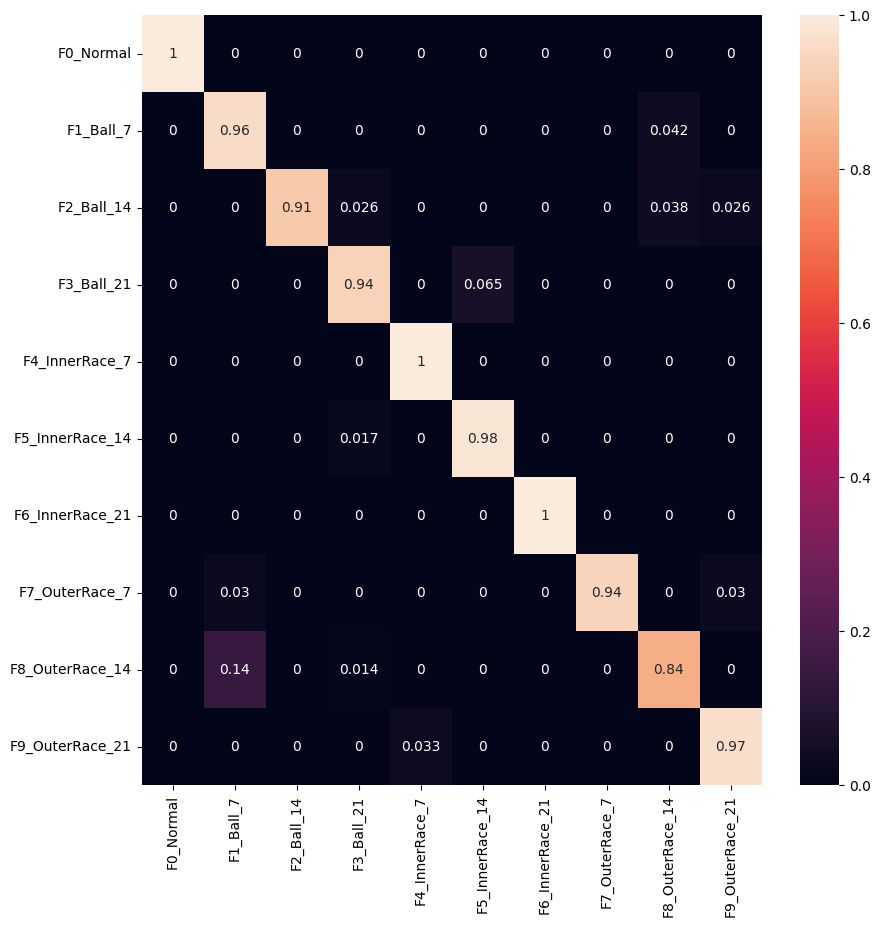

In [39]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [40]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.002s...
[t-SNE] Computed neighbors for 1570 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.098s
[t-SNE] Iteration 50: error = 55.5746193, gradient norm = 0.0636424 (50 iterations in 0.809s)
[t-SNE] Iteration 100: error = 50.5546837, gradient norm = 0.0176801 (50 iterations in 0.952s)
[t-SNE] Iteration 150: error = 49.3697014, gradient norm = 0.0090870 (50 iterations in 0.741s)
[t-SNE] Iteration 200: error = 48.7977943, gradient norm = 0.0081812 (50 iterations in 0.730s)
[t-SNE] Iteration 250: error = 48.4135475, gradient norm = 0.0065445 (50 iterations in 0.732s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.413548
[t-SNE] Iteration 300: error = 0.8569283, gradient norm = 0.0148881 (50 iterations in 0.735s

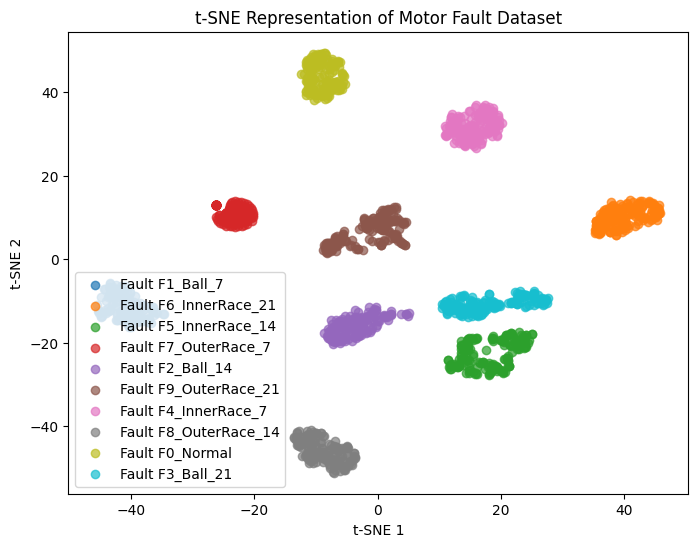

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [43]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2706, STRIDE: 2164
Extracted 2243 rows (target: 1800)
                fault  window      mean       std       rms       max  \
0           F0_Normal       1  0.008517  0.064628  0.065187  0.204443   
1           F0_Normal       2  0.009602  0.063451  0.064174  0.204860   
2           F0_Normal       3  0.010599  0.064361  0.065228  0.211327   
3           F0_Normal       4  0.012741  0.064404  0.065652  0.211536   
4           F0_Normal       5  0.012252  0.061830  0.063032  0.186919   
...               ...     ...       ...       ...       ...       ...   
2238  F9_OuterRace_21     221  0.013152  0.649244  0.649378  4.648259   
2239  F9_OuterRace_21     222  0.012568  0.536755  0.536902  4.377827   
2240  F9_OuterRace_21     223  0.013174  0.685940  0.686067  5.076443   
2241  F9_OuterRace_21     224  0.014050  0.626737  0.626894  3.700912   
2242  F9_OuterRace_21     225  0.011118  0.415185  0.415334  2.776936   

           min  skewness   kurtosis  form_fac

In [44]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
F6_InnerRace_21    226
F5_InnerRace_14    225
F9_OuterRace_21    225
F1_Ball_7          224
F4_InnerRace_7     224
F2_Ball_14         224
F7_OuterRace_7     224
F3_Ball_21         224
F8_OuterRace_14    224
F0_Normal          223
Name: count, dtype: int64
Current rows after equal resampling: 1570
New class distribution:
fault
F0_Normal          157
F7_OuterRace_7     157
F9_OuterRace_21    157
F3_Ball_21         157
F2_Ball_14         157
F1_Ball_7          157
F6_InnerRace_21    157
F5_InnerRace_14    157
F4_InnerRace_7     157
F8_OuterRace_14    157
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [45]:
balanced_df.shape

(1570, 11)

In [46]:
balanced_df=balanced_df.sort_values(by='fault')

In [47]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F0_Normal,43,0.009751,0.065139,0.065864,0.212996,-0.215708,-0.274433,-0.045461,1.236035,3.233858
1165,F0_Normal,36,0.011293,0.062924,0.063929,0.186711,-0.168561,-0.184237,-0.387789,1.219560,2.920578
1143,F0_Normal,54,0.012011,0.065607,0.066698,0.229060,-0.212788,-0.250128,-0.149889,1.231087,3.434300
1132,F0_Normal,34,0.010876,0.066891,0.067769,0.205069,-0.223218,-0.129397,-0.125704,1.245186,3.025978
1124,F0_Normal,124,0.007138,0.064205,0.064601,0.184625,-0.201522,-0.142130,-0.294445,1.226859,2.857937
...,...,...,...,...,...,...,...,...,...,...,...
60,F9_OuterRace_21,119,0.012091,0.590053,0.590177,4.476317,-4.531405,-0.231919,21.559533,2.147469,7.584706
503,F9_OuterRace_21,20,0.016847,0.564573,0.564825,4.379496,-5.038048,-1.139300,25.857851,2.183795,7.753727
171,F9_OuterRace_21,83,0.013734,0.547218,0.547391,2.989776,-3.105795,-0.225552,8.289343,1.751785,5.461870
804,F9_OuterRace_21,213,0.016183,0.589297,0.589519,3.952147,-4.732560,-0.793820,17.741390,1.972937,6.704016


     t-SNE 1    t-SNE 2      fault
0  20.589178 -26.294727  F0_Normal
1  21.865967 -25.317852  F0_Normal
2  36.331886  26.323563  F0_Normal
3  34.368561  27.613844  F0_Normal
4  24.151545 -23.021561  F0_Normal


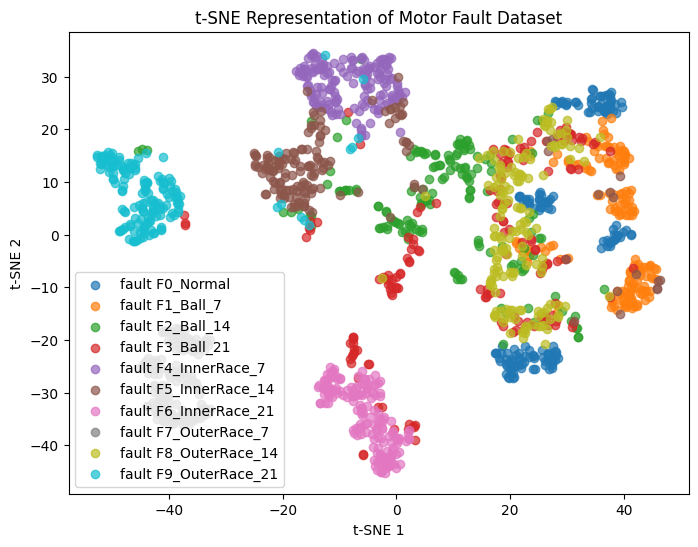

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [49]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,20.589178,-26.294727,F0_Normal
1,21.865967,-25.317852,F0_Normal
2,36.331886,26.323563,F0_Normal
3,34.368561,27.613844,F0_Normal
4,24.151545,-23.021561,F0_Normal
...,...,...,...
1565,-20.313269,5.805176,F9_OuterRace_21
1566,-44.253036,8.594396,F9_OuterRace_21
1567,-51.705292,13.964042,F9_OuterRace_21
1568,-41.454113,0.978268,F9_OuterRace_21


In [50]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,20.589178,-26.294727
1,21.865967,-25.317852
2,36.331886,26.323563
3,34.368561,27.613844
4,24.151545,-23.021561
...,...,...
1565,-20.313269,5.805176
1566,-44.253036,8.594396
1567,-51.705292,13.964042
1568,-41.454113,0.978268


In [51]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [52]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
888,-7.376735,41.808365,F0_Normal
998,-9.514571,47.755596,F0_Normal
556,-7.151873,47.126842,F0_Normal
564,-11.103809,40.269238,F0_Normal
981,-9.043150,48.075455,F0_Normal
...,...,...,...
1163,1.845452,6.685942,F9_OuterRace_21
912,0.453424,10.294040,F9_OuterRace_21
915,-2.029155,8.408968,F9_OuterRace_21
513,-1.188102,8.974256,F9_OuterRace_21


Combined Features

In [53]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
888,-16.741083,9.191854,-7.376735,41.808365,F0_Normal
998,-0.734401,-41.108902,-9.514571,47.755596,F0_Normal
556,22.521755,16.623198,-7.151873,47.126842,F0_Normal
564,-0.936125,-9.666546,-11.103809,40.269238,F0_Normal
981,-2.622202,-43.235096,-9.043150,48.075455,F0_Normal
...,...,...,...,...,...
1163,-42.220795,-32.001560,1.845452,6.685942,F9_OuterRace_21
912,-14.629620,11.087728,0.453424,10.294040,F9_OuterRace_21
915,-16.312887,9.704349,-2.029155,8.408968,F9_OuterRace_21
513,29.685680,-4.651138,-1.188102,8.974256,F9_OuterRace_21


In [54]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [55]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [56]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [57]:
!pip install hyperactive==4.6.0

In [58]:
!pip install catboost

Deployment:

In [63]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin # Import necessary base classes

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === CatBoost Classifier Wrapper for Scikit-learn compatibility ===
class CatBoostClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, iterations=100, depth=6, learning_rate=0.03, l2_leaf_reg=3, bagging_temperature=1, random_strength=1, **kwargs):
        self.iterations = iterations
        self.depth = depth
        self.learning_rate = learning_rate
        self.l2_leaf_reg = l2_leaf_reg
        self.bagging_temperature = bagging_temperature
        self.random_strength = random_strength
        self.catboost_model = CatBoostClassifier(
            iterations=self.iterations,
            depth=self.depth,
            learning_rate=self.learning_rate,
            l2_leaf_reg=self.l2_leaf_reg,
            bagging_temperature=self.bagging_temperature,
            random_strength=self.random_strength,
            verbose=False,
            **kwargs # Pass any additional kwargs to CatBoostClassifier
        )

    def fit(self, X, y, **fit_params):
        self.catboost_model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return self.catboost_model.predict(X)

    def predict_proba(self, X):
        return self.catboost_model.predict_proba(X)

    def get_params(self, deep=True):
        # This method is required by sklearn utilities like cross_val_score
        return {
            'iterations': self.iterations,
            'depth': self.depth,
            'learning_rate': self.learning_rate,
            'l2_leaf_reg': self.l2_leaf_reg,
            'bagging_temperature': self.bagging_temperature,
            'random_strength': self.random_strength,
        }

    def set_params(self, **params):
        for parameter, value in params.items():
            setattr(self, parameter, value)
        self.catboost_model.set_params(**params)
        return self

# === Objective Function ===
def model(opt):
    # Use the wrapper class instead of raw CatBoostClassifier
    catboost_wrapper = CatBoostClassifierWrapper(**opt)
    scores = cross_val_score(catboost_wrapper, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [13:27<00:00, 20.19s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 1.0  
   Best parameter set:
      'iterations'          : 50.0  
      'depth'               : 10.0  
      'learning_rate'       : 0.01  
      'l2_leaf_reg'         : 5.0  
      'bagging_temperature' : 1.5  
      'random_strength'     : 0.5  
   Best iteration: 0  
 
   Random seed: 731685805  
 
   Evaluation time   : 807.4737083911896 sec    [100.0 %]
   Optimization time : 0.011138916015625 sec    [0.0 %]
   Iteration time    : 807.4848473072052 sec    [20.19 sec/iter]
 
Tuning Duration: 0:13:27.738934
Best Parameters: {'iterations': 50, 'depth': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'bagging_temperature': 1.5, 'random_strength': 0.5}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2604611	test: 2.2599034	best: 2.2599034 (0)	total: 111ms	remaining: 5.45s
5:	learn: 2.0590650	test: 2.0598182	best: 2.0598182 (5)	total: 558ms	remaining: 4.09s
10:	learn: 1.9020002	test: 1.9017757	best: 1.9017757 (10)	total: 1.09s	remaining: 3.87s
15:	learn: 1.7586194	test: 1.7587786	best: 1.7587786 (15)	total: 1.64s	remaining: 3.48s
20:	learn: 1.6280512	test: 1.6293781	best: 1.6293781 (20)	total: 2.09s	remaining: 2.89s
25:	learn: 1.5207765	test: 1.5236291	best: 1.5236291 (25)	total: 2.63s	remaining: 2.43s
30:	learn: 1.4231312	test: 1.4271905	best: 1.4271905 (30)	total: 3.16s	remaining: 1.94s
35:	learn: 1.3345298	test: 1.3405510	best: 1.3405510 (35)	total: 3.96s	remaining: 1.54s
40:	learn: 1.2560230	test: 1.2640479	best: 1.2640479 (40)	total: 4.83s	remaining: 1.06s
45:	learn: 1.1774746	test: 1.1862952	best: 1.1862952 (45)	total: 5.75s	remaining: 500ms
49:	learn: 1.1253676	test: 1.1348547	best: 1.1348547 (49)	total: 6.46s	remaining: 0us

bestTest = 1.134854686
bestIteration 

In [64]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [65]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [2.2604610517884836, 2.225986962968271, 2.1735856467533816, 2.133945551558312, 2.100172771738813, 2.059064961637857, 2.0229651109980966, 1.984268297984024, 1.953920359207001, 1.9280549352112246, 1.9020001865700489, 1.8734629246426895, 1.8485699037648455, 1.8147449797751094, 1.7913589394341116, 1.7586193612436736, 1.7306331514360742, 1.700272589492072, 1.6740704471407122, 1.6533780448298383, 1.6280511594999423, 1.6099344071440937, 1.5871283374902463, 1.563781902319463, 1.538107828294285, 1.5207765464728864, 1.5002980634611691, 1.4832275824148784, 1.4625932548360725, 1.4433995169330007, 1.4231312042926827, 1.4043056159244902, 1.3870644791760727, 1.3689828091577239, 1.3506135377389046, 1.3345297830383867, 1.3159560146941107, 1.2989850140830699, 1.2883618755015631, 1.2694060836466954, 1.2560230073327434, 1.2412996640777616, 1.2234311440019003, 1.2057203380350943, 1.1905472161207602, 1.1774746390905397, 1.164601953728634, 1.154055642044997, 1.1406528064891774, 1.125

In [66]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [2.2604610517884836, 2.225986962968271, 2.1735856467533816, 2.133945551558312, 2.100172771738813, 2.059064961637857, 2.0229651109980966, 1.984268297984024, 1.953920359207001, 1.9280549352112246, 1.9020001865700489, 1.8734629246426895, 1.8485699037648455, 1.8147449797751094, 1.7913589394341116, 1.7586193612436736, 1.7306331514360742, 1.700272589492072, 1.6740704471407122, 1.6533780448298383, 1.6280511594999423, 1.6099344071440937, 1.5871283374902463, 1.563781902319463, 1.538107828294285, 1.5207765464728864, 1.5002980634611691, 1.4832275824148784, 1.4625932548360725, 1.4433995169330007, 1.4231312042926827, 1.4043056159244902, 1.3870644791760727, 1.3689828091577239, 1.3506135377389046, 1.3345297830383867, 1.3159560146941107, 1.2989850140830699, 1.2883618755015631, 1.2694060836466954, 1.2560230073327434, 1.2412996640777616, 1.2234311440019003, 1.2057203380350943, 1.1905472161207602, 1.1774746390905397, 1.164601953728634, 1.154055642044997, 1.1406528064891774, 1.1253

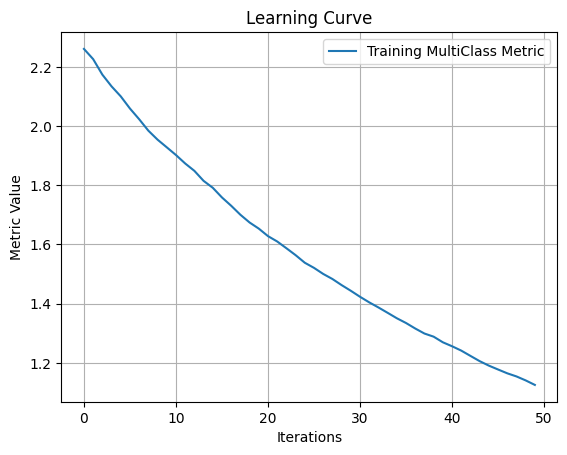

In [67]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                 precision    recall  f1-score   support

      F0_Normal       1.00      1.00      1.00       123
      F1_Ball_7       1.00      1.00      1.00       118
     F2_Ball_14       1.00      0.99      1.00       117
     F3_Ball_21       0.99      1.00      1.00       131
 F4_InnerRace_7       1.00      1.00      1.00       129
F5_InnerRace_14       1.00      1.00      1.00       130
F6_InnerRace_21       1.00      1.00      1.00       130
 F7_OuterRace_7       1.00      1.00      1.00       118
F8_OuterRace_14       1.00      1.00      1.00       130
F9_OuterRace_21       1.00      1.00      1.00       130

       accuracy                           1.00      1256
      macro avg       1.00      1.00      1.00      1256
   weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
                 precision    recall  f1-score   support

      F0_Normal       1.00      1.00      1.00        27
      F1_Bal

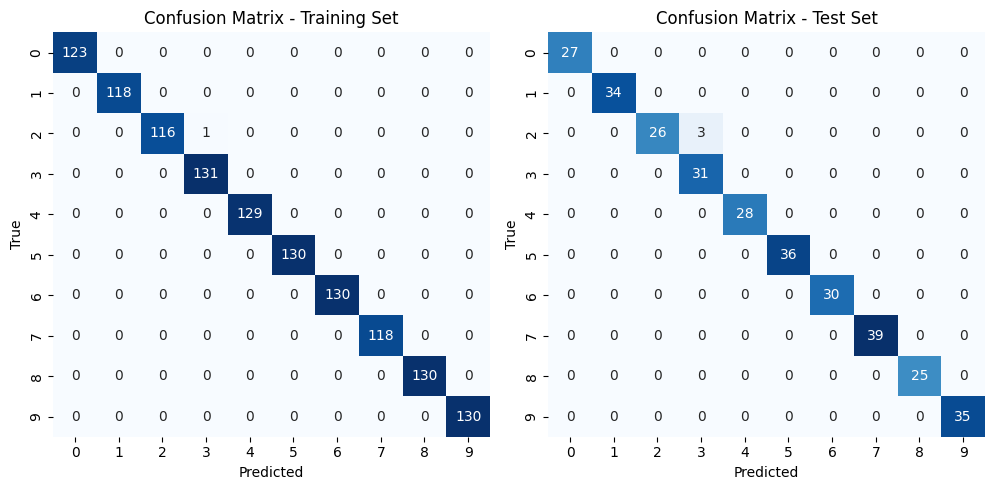

Deployment Duration: 0:14:57.431949


In [68]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [69]:
final_model = CatBoostClassifier(
    **final_model.get_params(),   # 保留你已經設定好的超參數
    eval_metric="Accuracy",
    verbose=50
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

# 取得 CatBoost 訓練過程紀錄
curve = final_model.get_evals_result()

# 取出 Accuracy 曲線
train_acc = curve["learn"]["Accuracy"]
val_acc   = curve["validation"]["Accuracy"]

# 繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 2.2604611	test: 2.2599034	best: 2.2599034 (0)	total: 127ms	remaining: 6.25s
10:	learn: 1.9020002	test: 1.9017757	best: 1.9017757 (10)	total: 1.62s	remaining: 5.74s
20:	learn: 1.6280512	test: 1.6293781	best: 1.6293781 (20)	total: 3.28s	remaining: 4.53s
30:	learn: 1.4231312	test: 1.4271905	best: 1.4271905 (30)	total: 4.64s	remaining: 2.85s
40:	learn: 1.2560230	test: 1.2640479	best: 1.2640479 (40)	total: 5.7s	remaining: 1.25s
49:	learn: 1.1253676	test: 1.1348547	best: 1.1348547 (49)	total: 6.65s	remaining: 0us

bestTest = 1.134854686
bestIteration = 49

Train Accuracy : 0.9992038216560509
Test Accuracy : 0.9904458598726115
Classification Report - Training Set:
                 precision    recall  f1-score   support

      F0_Normal       1.00      1.00      1.00       123
      F1_Ball_7       1.00      1.00      1.00       118
     F2_Ball_14       1.00      0.99      1.00       117
     F3_Ball_21       0.99      1.00      1.00       131
 F4_InnerRace_7       1.00      1.00  